In [1]:
import os
import yaml
import pickle
from scipy import stats
import numpy as np
import pandas as pd
import altair as alt

from copy import deepcopy
from sklearn.linear_model import Lasso, LinearRegression, Ridge, PoissonRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

np.random.seed(42)
alt.data_transformers.disable_max_rows()
alt.renderers.enable('mimetype');

### Prepare Data

In [2]:
with open("config.yaml", "r") as config_file:
    config = yaml.full_load(config_file)
    data_path = config["data_path"]
    models_path = config["models_path"]

In [3]:
sales_df = pd.read_csv(os.path.join(data_path, "preprocessed_data.csv"))
sales_df["dt"] = pd.to_datetime(sales_df["dt"])
sales_df.head(3)

,dt,inventory,units,adspend,rank
0,2017-09-26,693,36,83.79,51432
1,2017-09-27,673,34,67.16,48596
2,2017-09-28,626,33,50.49,43191


In [4]:
def create_lag_df(ts, lags, zero_lag=True):
    df = pd.DataFrame({f"{ts.name}_lag0": ts})
    
    for lag in range(1, lags + 1):
        df[f"{ts.name}_lag{lag}"] = ts.shift(lag)
    
    if not zero_lag:
        df.drop(f"{ts.name}_lag0", axis=1, inplace=True)
    return df

In [5]:
inventory_lags = 0
adspend_lags = 0
rank_lags = 15
units_lags = 3

In [6]:
max_lag = max(inventory_lags, adspend_lags, rank_lags, units_lags)

x = pd.concat((create_lag_df(sales_df["units"], units_lags, zero_lag=False),
               create_lag_df(sales_df["rank"], rank_lags),
               create_lag_df(sales_df["inventory"], inventory_lags),
               create_lag_df(sales_df["adspend"], adspend_lags)), axis=1)
y = sales_df["units"]

x, y = x.iloc[max_lag:], y.iloc[max_lag:]
print(x.shape, y.shape)
x.head(3)

(1043, 21) (1043,)


,units_lag1,units_lag2,units_lag3,rank_lag0,rank_lag1,rank_lag2,rank_lag3,rank_lag4,rank_lag5,rank_lag6,...,rank_lag8,rank_lag9,rank_lag10,rank_lag11,rank_lag12,rank_lag13,rank_lag14,rank_lag15,inventory_lag0,adspend_lag0
15,21.0,40.0,39.0,45995,37812.0,59049.0,48368.0,32732.0,55959.0,55959.0,...,68259.0,30705.0,29923.0,39509.0,78695.0,43191.0,48596.0,51432.0,234,56.09
16,30.0,21.0,40.0,171846,45995.0,37812.0,59049.0,48368.0,32732.0,55959.0,...,55959.0,68259.0,30705.0,29923.0,39509.0,78695.0,43191.0,48596.0,216,35.26
17,22.0,30.0,21.0,330080,171846.0,45995.0,37812.0,59049.0,48368.0,32732.0,...,55959.0,55959.0,68259.0,30705.0,29923.0,39509.0,78695.0,43191.0,210,39.54


In [7]:
test_set_size = 90
x_train, x_test, y_train, y_test = x.iloc[: -test_set_size], x.iloc[-test_set_size:], y.iloc[: -test_set_size], y.iloc[-test_set_size:]

### Models training

In [8]:
def get_lag_subset(df, inventory_lags, adspend_lags, rank_lags, units_lags):
    columns = [f"units_lag{lag}" for lag in range(1, units_lags + 1)] + \
              [f"rank_lag{lag}" for lag in range(rank_lags + 1)] + \
              [f"inventory_lag{lag}" for lag in range(inventory_lags + 1)] + \
              [f"adspend_lag{lag}" for lag in range(adspend_lags + 1)]
    return df[columns]

In [9]:
# WMAPE metric
def wmape(y, y_hat):
    return np.abs((y - y_hat)).sum() / y.sum()

In [10]:
# RMSE metric
def rmse(y, y_hat):
    return np.sqrt(((y - y_hat) ** 2).mean())

In [11]:
# iterator for GridSearch
def folds_iterator(n_folds, samples_per_fold, size):
    for i in range(n_folds):
        yield np.arange(0, size - samples_per_fold * (i + 1)), \
              np.arange(size - samples_per_fold * (i + 1), size - samples_per_fold * i)

In [12]:
def validate_model(model, x, y, params, n_folds, samples_per_fold):
    grid_search = GridSearchCV(estimator=model,
                               param_grid=params,
                               scoring={"RMSE": make_scorer(rmse, greater_is_better=False), "WMAPE": make_scorer(wmape, greater_is_better=False)},
                               refit="RMSE",
                               n_jobs=-1, cv=folds_iterator(n_folds, samples_per_fold, x.shape[0]))
    grid_search.fit(x, y)
    best_index = grid_search.best_index_
    return grid_search.best_estimator_, grid_search.cv_results_["mean_test_RMSE"][best_index], grid_search.cv_results_["mean_test_WMAPE"][best_index], grid_search.best_params_

In [13]:
def validate_lags(model, x, y, params, n_folds, samples_per_fold):
    best_rmse = -np.Inf
    
    for inventory_lag in range(inventory_lags + 1):
        for adspend_lag in range(adspend_lags + 1):
            for rank_lag in range(rank_lags + 1):
                for units_lag in range(1, units_lags + 1):
                    cur_x = get_lag_subset(x, inventory_lag, adspend_lag, rank_lag, units_lag)
                    cur_model, cur_rmse, cur_wmape, cur_params = validate_model(deepcopy(model), cur_x, y, params, n_folds, samples_per_fold)
                    
                    if cur_rmse > best_rmse:
                        best_rmse = cur_rmse
                        best_wmape = cur_wmape
                        best_model = cur_model
                        best_params = cur_params
                        best_inventory_lag = inventory_lag
                        best_adspend_lag = adspend_lag
                        best_rank_lag = rank_lag
                        best_units_lag = units_lag
    
    print(f"Best lags number:\nInventory: {best_inventory_lag};\nAdspend: {best_adspend_lag}\nRank: {best_rank_lag}\nUnits: {best_units_lag}")
    
    print("\nBest hyper-parameters")
    for param_name in best_params:
        print(f"{param_name}: {best_params[param_name]}")

    print(f"\nRMSE: {best_rmse}; WMAPE: {best_wmape}")
    
    return best_model

In [14]:
n_folds = 3
samples_per_fold = test_set_size

In [15]:
linear_regression = validate_lags(model=Pipeline([("scl", StandardScaler()), ("reg", LinearRegression())]), 
                                  x=x_train,
                                  y=y_train,
                                  params={},
                                  n_folds=n_folds,
                                  samples_per_fold=samples_per_fold)

Best lags number:
Inventory: 0;
Adspend: 0
Rank: 5
Units: 2

Best hyper-parameters

RMSE: -31.515565490937146; WMAPE: -0.16572408046229548


In [17]:
ridge = validate_lags(model=Pipeline([("scl", StandardScaler()), ("reg", Ridge(random_state=42))]), 
                      x=x_train,
                      y=y_train,
                      params={"reg__alpha": [0.01, 0.1, 1, 10]},
                      n_folds=n_folds,
                      samples_per_fold=samples_per_fold)

Best lags number:
Inventory: 0;
Adspend: 0
Rank: 5
Units: 2

Best hyper-parameters
reg__alpha: 0.01

RMSE: -31.515750654289135; WMAPE: -0.16572550219471258


In [18]:
poisson_regression = validate_lags(model=Pipeline([("scl", StandardScaler()), ("reg", PoissonRegressor())]), 
                                   x=x_train,
                                   y=y_train,
                                   params={"reg__alpha": [0.01, 0.1, 1, 10]},
                                   n_folds=n_folds,
                                   samples_per_fold=samples_per_fold)

Best lags number:
Inventory: 0;
Adspend: 0
Rank: 5
Units: 3

Best hyper-parameters
reg__alpha: 10

RMSE: -37.35794888815844; WMAPE: -0.1970146143824709


In [19]:
svr = validate_lags(model=Pipeline([("scl", StandardScaler()), ("reg", SVR())]), 
                    x=x_train,
                    y=y_train,
                    params={"reg__C": [0.01, 0.1, 1, 10],
                            "reg__kernel": ["rbf", "linear"]},
                    n_folds=n_folds,
                    samples_per_fold=samples_per_fold)

Best lags number:
Inventory: 0;
Adspend: 0
Rank: 4
Units: 2

Best hyper-parameters
reg__C: 10
reg__kernel: linear

RMSE: -29.773697477620065; WMAPE: -0.15072956926680622


In [20]:
random_forest = validate_lags(model=RandomForestRegressor(random_state=42),
                              x=x_train,
                              y=y_train,
                              params={"max_depth": [None, 3, 5, 6],
                                      "min_samples_split": [2, 4, 6],
                                      "n_estimators": [100, 200],
                                      "max_features": [0.4, 0.6, 0.8, 1.0]},
                              n_folds=n_folds,
                              samples_per_fold=samples_per_fold)

Best lags number:
Inventory: 0;
Adspend: 0
Rank: 8
Units: 2

Best hyper-parameters
max_depth: 5
max_features: 0.6
min_samples_split: 6
n_estimators: 200

RMSE: -28.29363284946308; WMAPE: -0.14283033702272083


In [23]:
gradient_boosting = validate_lags(model=GradientBoostingRegressor(random_state=42),
                                  x=x_train,
                                  y=y_train,
                                  params={"min_samples_split": [2, 3, 5],
                                          "max_depth": [2, 3, 5],
                                          "learning_rate": [0.01, 0.1, 1],
                                          "max_features": [0.4, 0.6, 0.8, 1.0]},
                                  n_folds=n_folds,
                                  samples_per_fold=samples_per_fold)

Best lags number:
Inventory: 0;
Adspend: 0
Rank: 8
Units: 2

Best hyper-parameters
learning_rate: 0.1
max_depth: 2
max_features: 0.8
min_samples_split: 3

RMSE: -28.461896076624356; WMAPE: -0.1435691286460768


### Test set evaluation

In [15]:
x_train, x_test = get_lag_subset(x_train, 0, 0, 8, 2), get_lag_subset(x_test, 0, 0, 8, 2)

In [24]:
y_hat = random_forest.predict(x_test)
wmape_score = wmape(y_test, y_hat)
rmse_score = rmse(y_test, y_hat)

predictions_df = pd.DataFrame({"dt": sales_df["dt"][-test_set_size:], "sales": y_test, "forcasted sales": y_hat})
predictions_df.head(3)

,dt,sales,forcasted sales
968,2020-05-21,166,173.553580
969,2020-05-22,149,180.909443
970,2020-05-23,174,141.398636


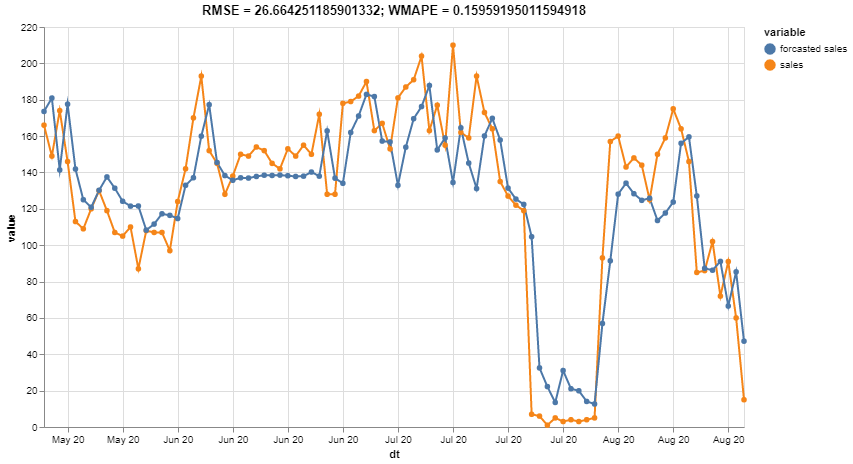

In [25]:
alt.Chart(pd.melt(predictions_df, "dt")).mark_line(point=True) \
.encode(
    x = alt.X("dt:T", axis=alt.Axis(format="%b %y")),
    y = alt.Y("value:Q"),
    color = alt.Color("variable:N")
).properties(width=700, height=400, title=f"RMSE = {rmse_score}; WMAPE = {wmape_score}")

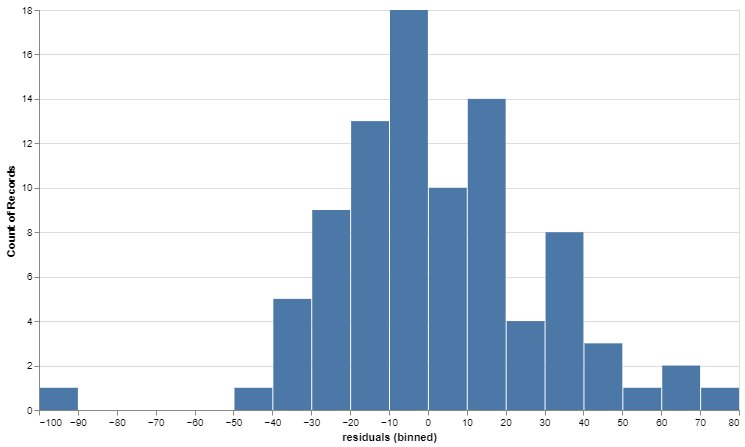

In [39]:
predictions_df["residuals"] = predictions_df["sales"] - predictions_df["forcasted sales"]
histogram = alt.Chart(predictions_df).mark_bar().encode(
    alt.X("residuals:Q", bin=alt.Bin(maxbins=30)),
    y='count()',
).properties(width=700, height=400)
histogram

In [23]:
x = pd.concat((x_train, x_test))
x.to_csv(os.path.join(data_path, "demand_input_features.csv"), index=False)

In [34]:
random_forest.fit(x, y);

In [35]:
pickle.dump(random_forest, open(os.path.join(models_path, "demand_forecasting_model2.pkl"), "wb"))

In [35]:
stat, p = stats.shapiro(predictions_df["residuals"])
print(f"Statistics = {stat}, p = {p}")

alpha = 0.01
if p > alpha:
    print("Sample looks Gaussian (fail to reject H0)")
else:
    print("Sample does not look Gaussian (reject H0)")

Statistics = 0.9715274572372437, p = 0.04532279074192047
Sample looks Gaussian (fail to reject H0)


In [36]:
mu, s = stats.norm.fit(predictions_df["residuals"])
print(f"mu = {mu}; sigma = {s}")

mu = 2.628900179728359; sigma = 26.53433954614029


In [38]:
np.save(os.path.join(models_path, "demand_residuals_parameters.npy"), np.array([mu, s]))

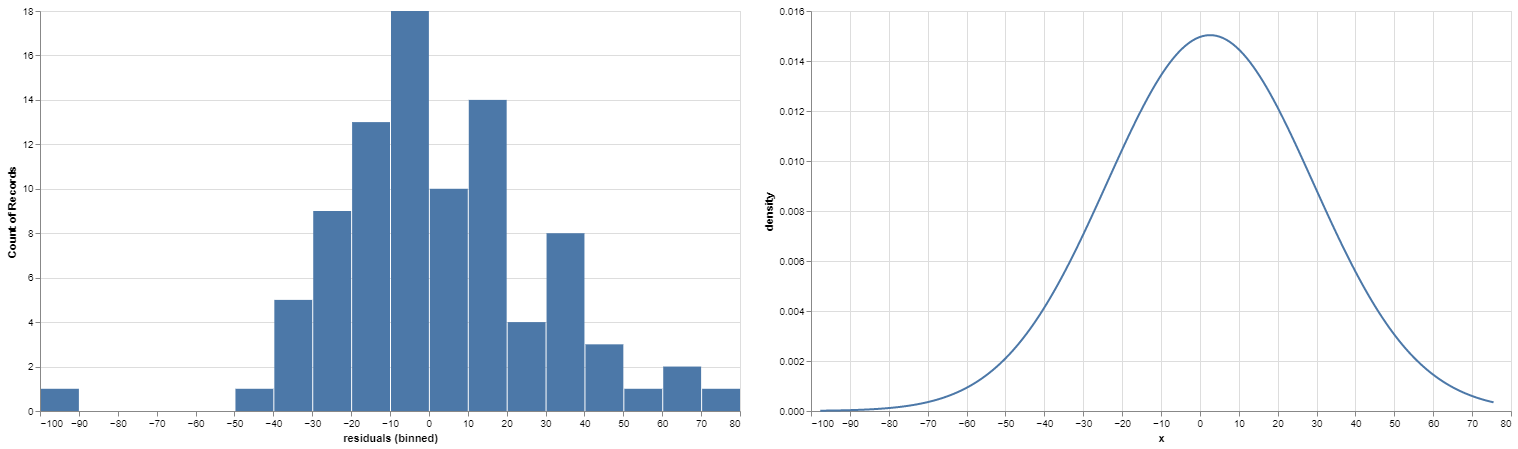

In [41]:
xt = np.linspace(predictions_df["residuals"].min(), predictions_df["residuals"].max(), 200)
density = stats.norm.pdf(xt, mu, s)

density_chart = alt.Chart(pd.DataFrame({"x": xt, "density": density})).mark_line() \
.encode(
    x = alt.X("x:Q"),
    y = alt.Y("density:Q"),
).properties(width=700, height=400)

alt.ConcatChart(concat=[histogram, density_chart])